In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNet

In [3]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

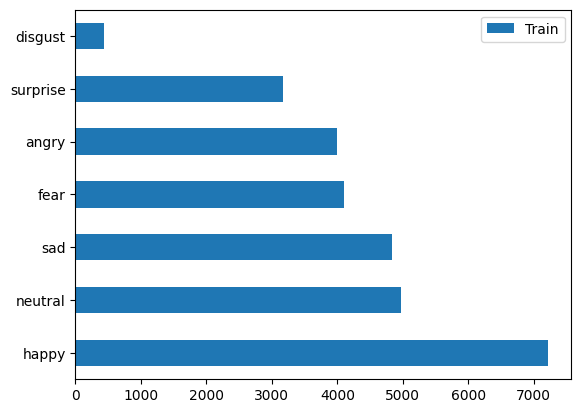

In [4]:
Train_Count.plot(kind='barh')


<Axes: >

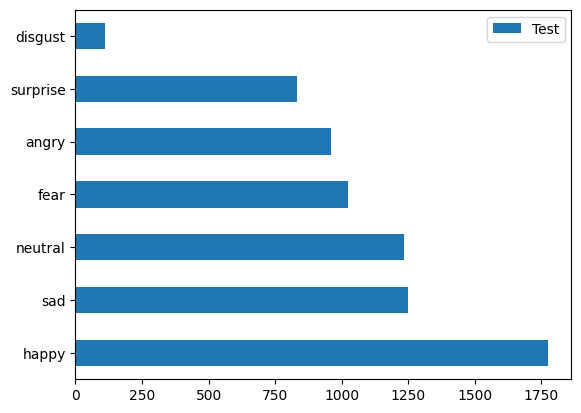

In [5]:
Test_Count.plot(kind='barh')

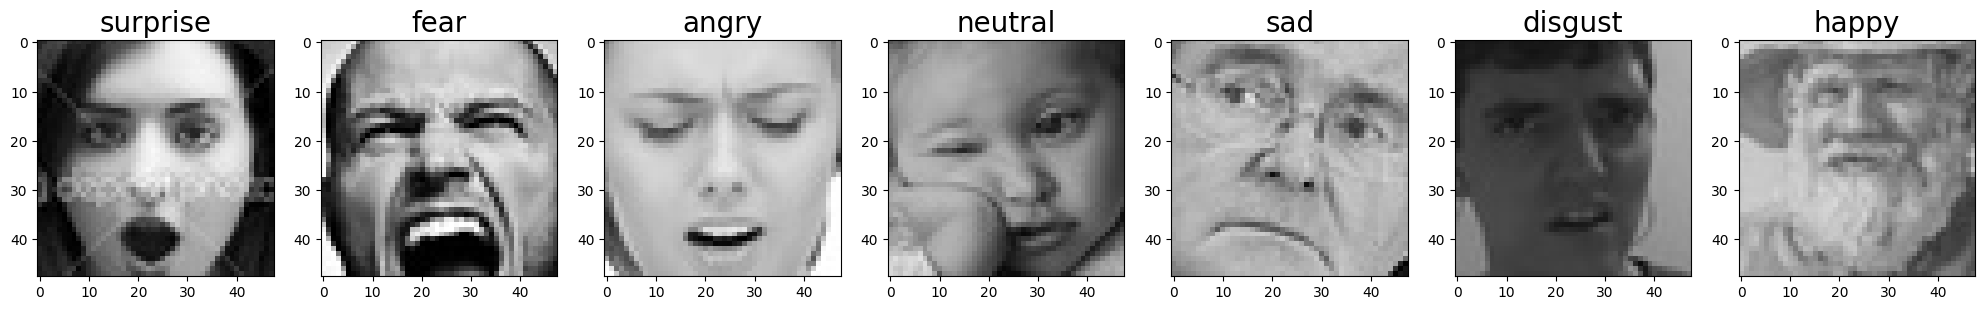

In [6]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '../input/fer2013/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

In [15]:
img_shape = 224
batch_size = 64
train_data_path = '../input/fer2013/train/'
test_data_path = '../input/fer2013/test/'

In [16]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

Found 28709 images belonging to 7 classes.


In [17]:
test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


In [18]:
MobileNet = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

MobileNet.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [19]:
# Freezing all layers except last 50

MobileNet.trainable = True

for layer in MobileNet.layers[:-20]:
    layer.trainable = False

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def Create_MobileNet_Model():
    inputs = Input(shape=(224, 224, 3))
    x = MobileNet(inputs)
    x = Dropout(.25)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    outputs = Dense(7, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [21]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()


In [22]:
MobileNet_Model = Create_MobileNet_Model()

MobileNet_Model.summary()

MobileNet_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,444,999 (24.59 MB)

 Trainable params: 5,076,615 (19.37 MB)

 Non-trainable params: 1,368,384 (5.22 MB)

In [25]:
# Create Callback Checkpoint
checkpoint_path = "MobileNet_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor="val_accuracy", 
    save_best_only=True,
    verbose=1
)
# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Checkpoint, Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [27]:
MobileNet_history = MobileNet_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=60,
    batch_size=batch_size,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5607 - loss: 1.1921 - precision_1: 0.7180 - recall_1: 0.3803
Epoch 1: val_accuracy improved from -inf to 0.57324, saving model to MobileNet_Model_Checkpoint.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.5607 - loss: 1.1921 - precision_1: 0.7180 - recall_1: 0.3803 - val_accuracy: 0.5732 - val_loss: 1.2827 - val_precision_1: 0.6946 - val_recall_1: 0.4328 - learning_rate: 0.0010
Epoch 2/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.5938 - loss: 0.9748 - precision_1: 0.7073 - recall_1: 0.4531

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.57324 to 0.90000, saving model to MobileNet_Model_Checkpoint.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5938 - loss: 0.9748 - precision_1: 0.7073 - recall_1: 0.4531 - val_accuracy: 0.9000 - val_loss: 0.3071 - val_precision_1: 0.9000 - val_recall_1: 0.9000 - learning_rate: 0.0010
Epoch 3/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6012 - loss: 1.0799 - precision_1: 0.7398 - recall_1: 0.4341
Epoch 3: val_accuracy did not improve from 0.90000
448/448 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.6012 - loss: 1.0799 - precision_1: 0.7398 - recall_1: 0.4341 - val_accuracy: 0.5857 - val_loss: 1.1604 - val_precision_1: 0.6748 - val_recall_1: 0.4965 - learning_rate: 0.0010
Epoch 4/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.7031 - loss: 0.8356 - precision_1: 0.8649 - recall_1: 0.5000
Epoch 4: val_accuracy did not improve from 0.90000
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 97us/step - accuracy: 0.7031 - loss: 0.83

In [31]:
MobileNet_Score = MobileNet_Model.evaluate(test_data)

print("Test Loss:     {:.5f}".format(MobileNet_Score[0]))
print("Test Accuracy: {:.2f}%".format(MobileNet_Score[1] * 100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - accuracy: 0.5960 - loss: 1.1948 - precision_1: 0.7124 - recall_1: 0.4646
Test Loss:     1.27631
Test Accuracy: 57.36%


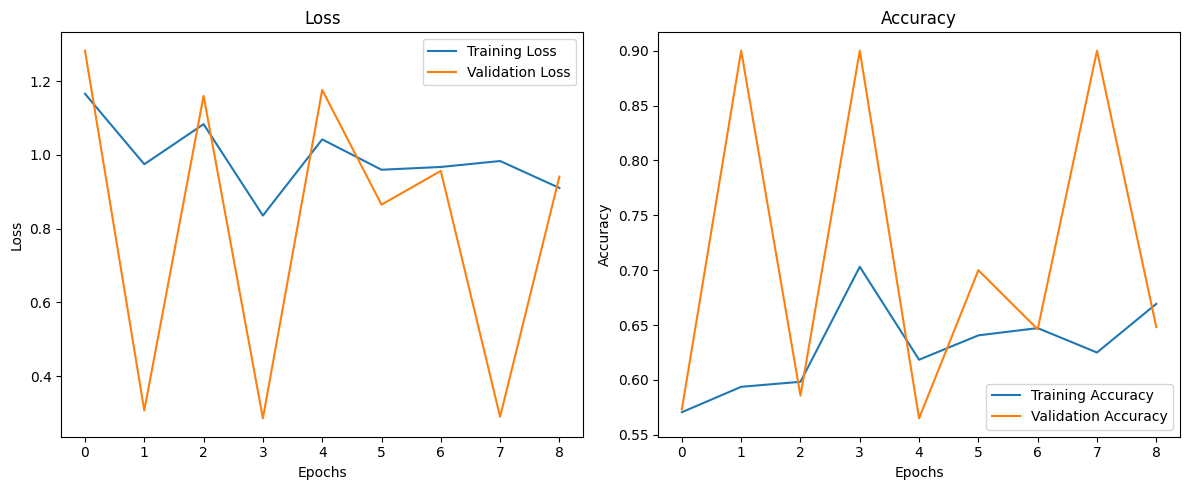

In [32]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    
    plt.figure(figsize=(12,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the plot_curves function after training
plot_curves(MobileNet_history)

In [33]:
MobileNet_Predictions = MobileNet_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
MobileNet_Predictions = np.argmax(MobileNet_Predictions, axis=1)

  3/113 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step

W0000 00:00:1723483878.884753     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step


In [36]:
history = MobileNet_history
final_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Validation Loss : {:.4f}".format(final_val_loss))

# Only print these if they're available in your history
if 'precision' in history.history:
    final_precision = history.history['precision'][-1]
    print("Final Precision       : {:.2%}".format(final_precision))

if 'recall' in history.history:
    final_recall = history.history['recall'][-1]
    print("Final Recall          : {:.2%}".format(final_recall))

if 'precision' in history.history and 'recall' in history.history:
    final_precision = history.history['precision'][-1]
    final_recall = history.history['recall'][-1]
    final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)
    print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 66.93%
Final Validation Loss : 0.9414


Text(0.5, 1.0, 'MobileNet Confusion Matrix')

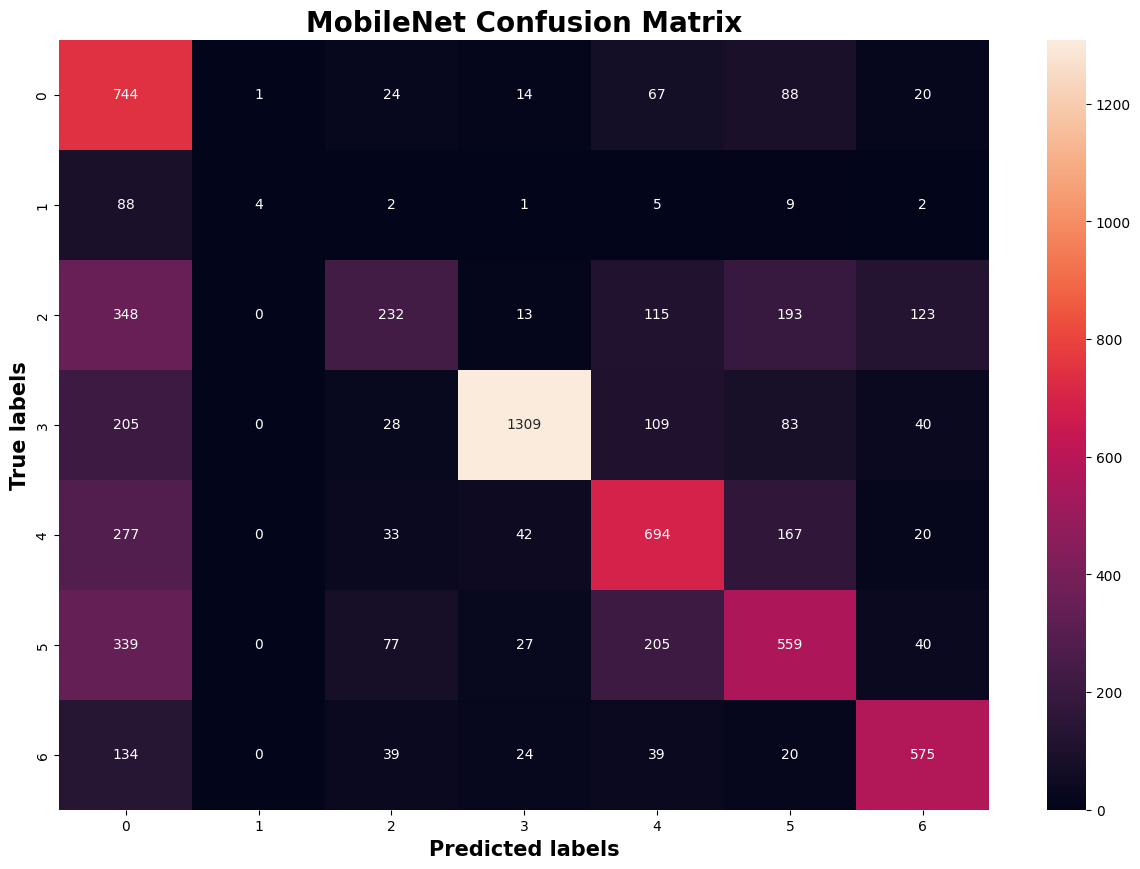

In [37]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, MobileNet_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('MobileNet Confusion Matrix', fontsize=20, fontweight='bold')

In [38]:
class_indices = test_data.class_indices
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]
print(Emotion_Classes)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [39]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


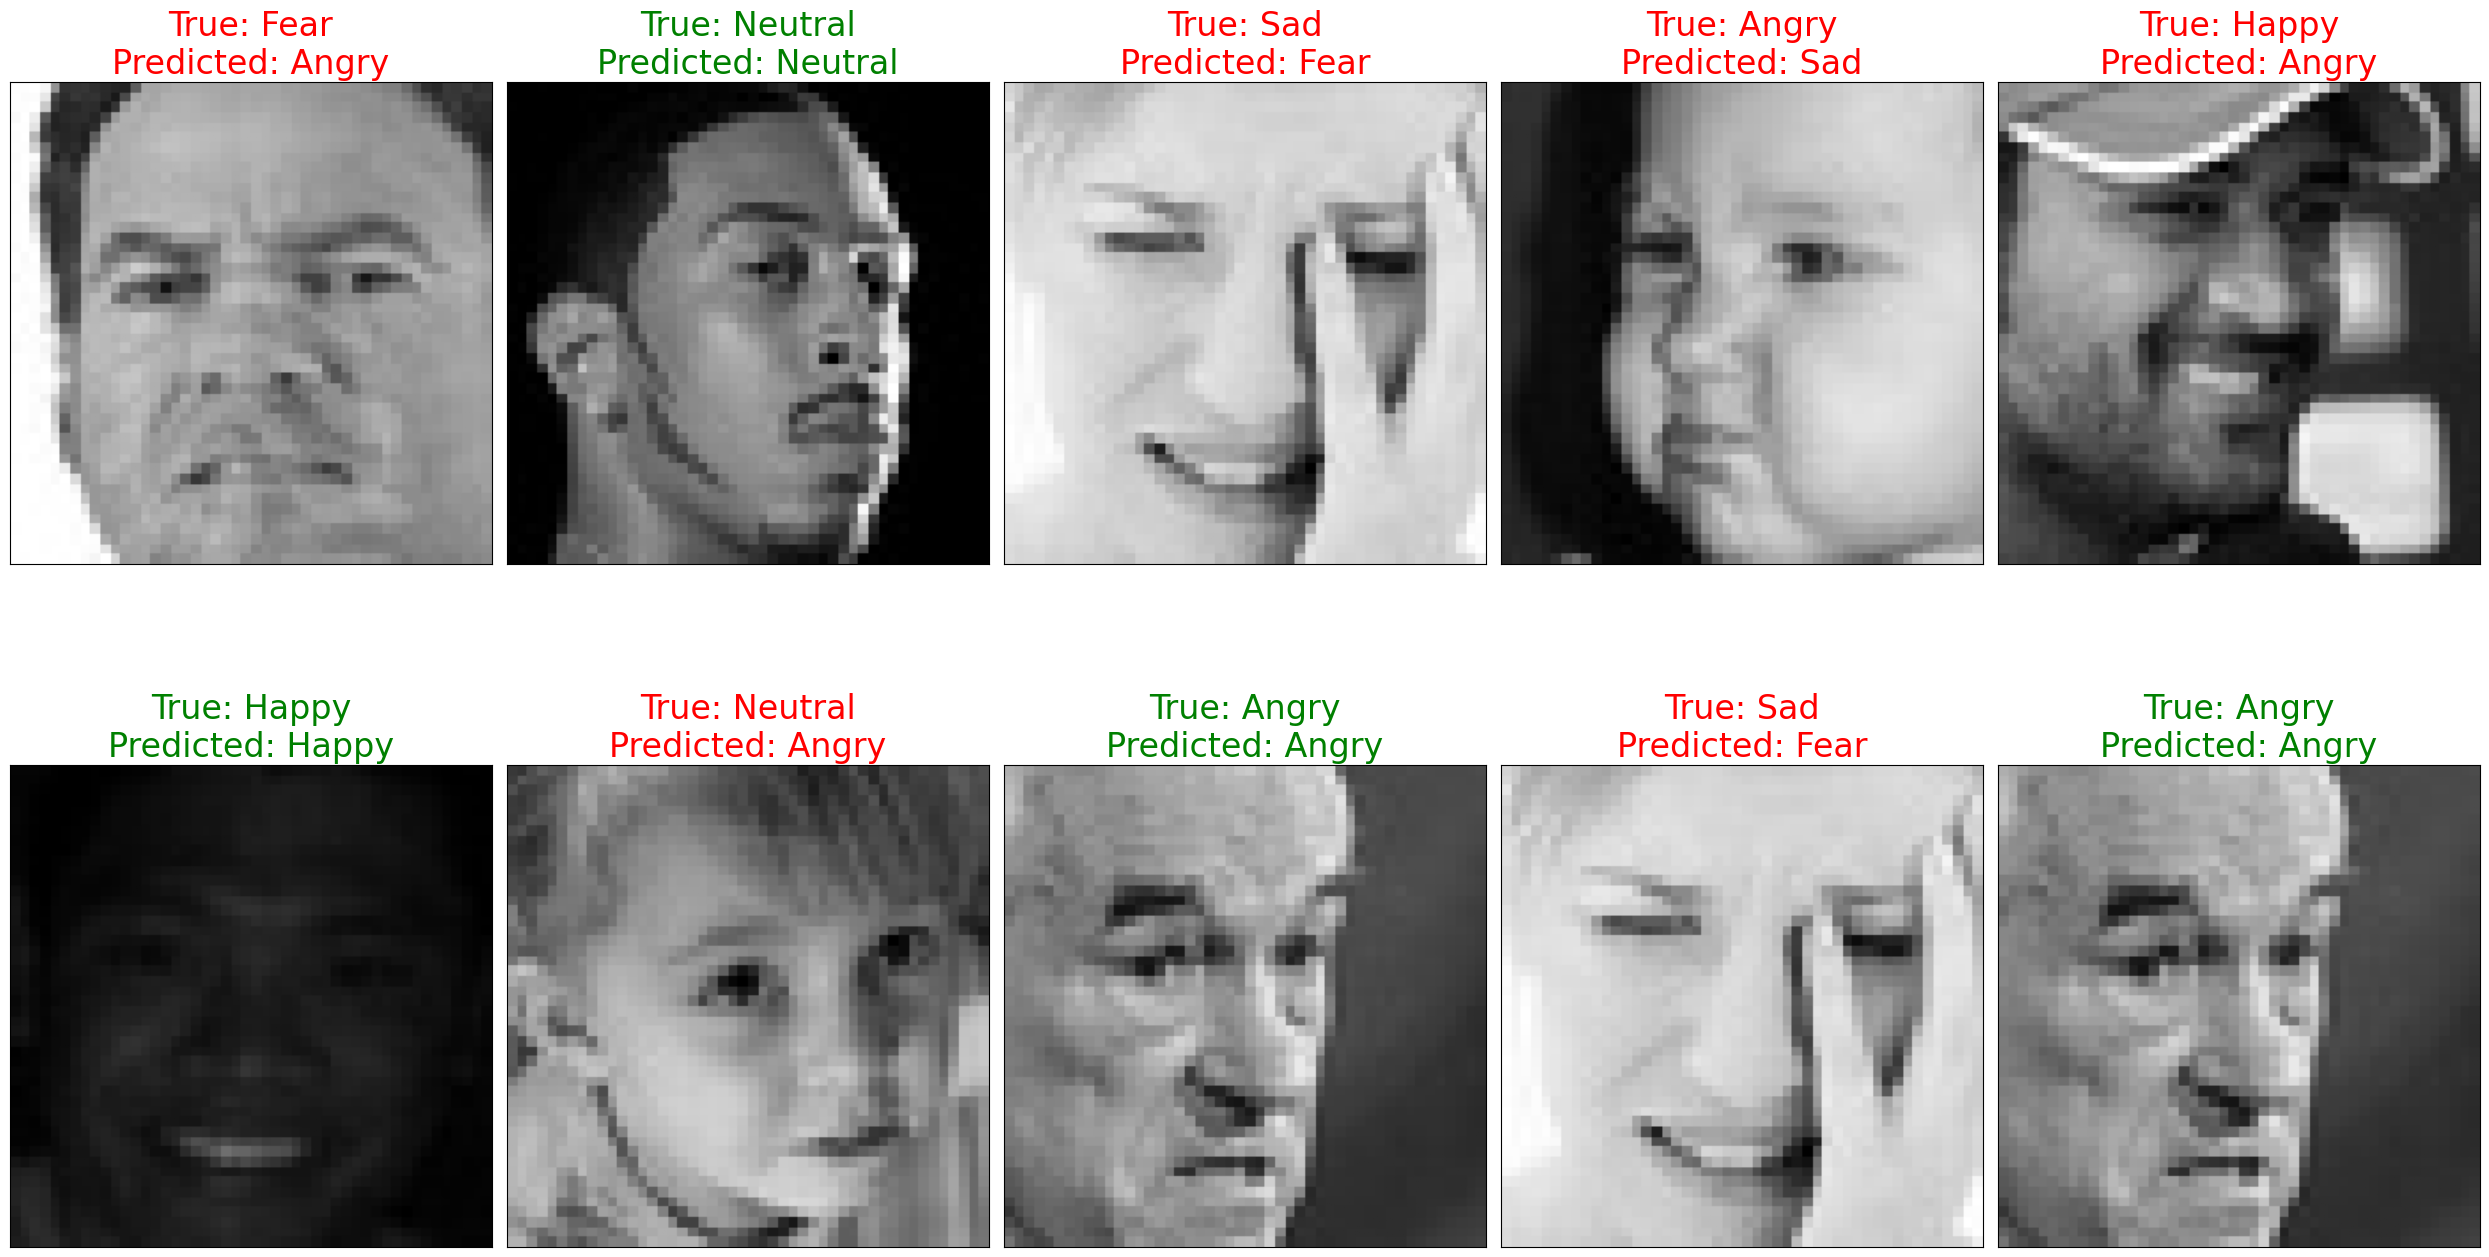

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Assuming test_generator contains your image data
# batch_size is the size of the batch
# Emotion_Classes is a list containing emotion classes

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_resized = resize(Random_Img, (224, 224), anti_aliasing=True)

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(MobileNet_Model.predict(Random_Img_resized.reshape(1, 224, 224, 3), verbose=0))
    ax.imshow(Random_Img_resized)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
        
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color, fontsize=24)

plt.tight_layout()
plt.show()

Music recommendation

In [41]:
Music_Player = pd.read_csv("/kaggle/input/spotify-music-data/data_moods.csv")
Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [42]:
Music_Player["mood"].value_counts()


mood
Sad          197
Calm         195
Energetic    154
Happy        140
Name: count, dtype: int64

In [43]:
Music_Player["popularity"].value_counts()


popularity
0     92
51    23
52    22
50    21
55    21
      ..
12     1
8      1
14     1
15     1
88     1
Name: count, Length: 83, dtype: int64

In [44]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:3].reset_index(drop=True)
display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Escaping Time,Benjamin Martins,Calm,60
2,Curiosity,Beau Projet,Calm,60


In [45]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):
    
    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)
        
    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

In [46]:
Recommend_Songs("Fear")


,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Escaping Time,Benjamin Martins,Calm,60
2,Curiosity,Beau Projet,Calm,60
3,What You Love You Must Love Now,The Six Parts Seven,Calm,59
4,The Choice,Gustavo Santaolalla,Calm,59


In [47]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")    

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-08-12 17:33:23--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: 'haarcascade_frontalface_default.xml'

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2024-08-12 17:33:23 (15.4 MB/s) - 'haarcascade_frontalface_default.xml' saved [930127/930127]



In [48]:
import cv2
import matplotlib.pyplot as plt

def load_and_prep_image(filename, img_shape = 48):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
            
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [49]:
def pred_and_plot(filename, class_names, size):

    # Import the target image and preprocess it
    Random_Img = load_and_prep_image(filename, size)

    # Make a prediction
    Model_Prediction = np.argmax(MobileNet_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    pred_class = class_names[Model_Prediction]
    print("Sentiment Identified as: ", pred_class)
   
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()
    print()
    print("*" * 8, "Recommended Music", "*" * 8)
    print()
    Recommend_Songs(pred_class)

Sentiment Identified as:  Happy


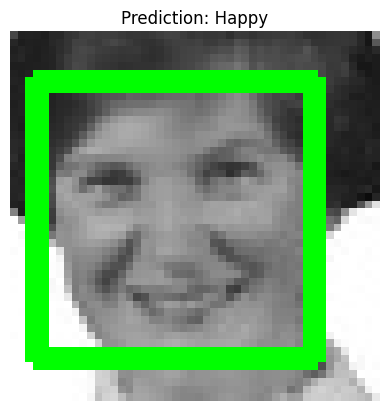


******** Recommended Music ********



,name,artist,mood,popularity
0,Pumped Up Kicks,Foster The People,Happy,84
1,Africa,TOTO,Happy,84
2,Take on Me,a-ha,Happy,84
3,Here Comes The Sun - Remastered 2009,The Beatles,Happy,83
4,Highway to Hell,AC/DC,Happy,83


In [50]:
pred_and_plot("../input/fer2013/test/happy/PrivateTest_218533.jpg", Emotion_Classes, 224)


In [51]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg" -O sad.jpg

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-08-12 17:33:32--  https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.173.16, 2606:2800:220:13d:2176:94a:948:148e
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.173.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36922 (36K) [image/jpeg]
Saving to: 'sad.jpg'

sad.jpg             100%[===================>]  36.06K  --.-KB/s    in 0.01s   

2024-08-12 17:33:32 (3.38 MB/s) - 'sad.jpg' saved [36922/36922]



Sentiment Identified as:  Sad


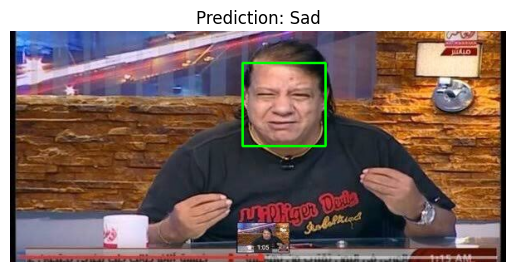


******** Recommended Music ********



,name,artist,mood,popularity
0,Pumped Up Kicks,Foster The People,Happy,84
1,Africa,TOTO,Happy,84
2,Take on Me,a-ha,Happy,84
3,Here Comes The Sun - Remastered 2009,The Beatles,Happy,83
4,Highway to Hell,AC/DC,Happy,83


In [52]:
pred_and_plot("./sad.jpg", Emotion_Classes, 224)


In [58]:
model = keras.models.load_model("Mobile_Net_music-d0.h5")

In [53]:
!pip3 install gradio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 66.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 87.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.12.5
    Uninstalling tomlkit-0.12.5:
      Successfully uninstalled tomlkit-0.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
distributed 2024.5.1 requires dask==2024.5.1, but you have dask 2024.7.0 which is incomp

In [54]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [59]:
model.save("Mobile_Net_music-d0.keras")

In [60]:
import os

# Save the model
model.save("Mobile_Net_music-d0.keras")

# Get the current working directory
current_directory = os.getcwd()

# Construct the full path to the saved model
model_path = os.path.join(current_directory, "Mobile_Net_music-d0.keras")

# Print the full path
print(f"The model is saved at: {model_path}")

The model is saved at: /kaggle/working/Mobile_Net_music-d0.keras


In [61]:
model = tf.keras.models.load_model('/kaggle/working/Mobile_Net_music-d0.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 54 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [62]:
# Emotion labels dictionary
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [ ]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()